## **Method of Importance Reweighting**

### Uncorrelated data

#### Main method

Weighted Logistic Regression - Mean accuracy: 0.5024, Standard deviation: 0.0340
Unweighted Logistic Regression - Mean accuracy: 0.8187, Standard deviation: 0.0795
SVM - Mean accuracy: 0.9143, Standard deviation: 0.0417


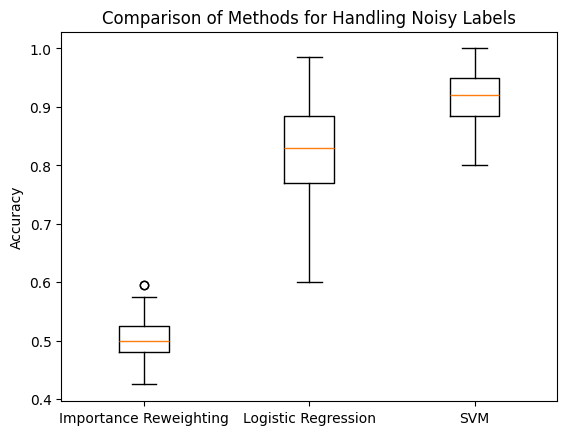

In [50]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate=0.2, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate = noise_rate
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """

        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)

        self.y_noisy = self.y.copy()
        n_noisy = int(self.noise_rate * self.y.shape[0])
        
        # Introduce noise while ensuring no class is fully eliminated
        class_1_indices = np.where(self.y_noisy == 1)[0]
        class_minus_1_indices = np.where(self.y_noisy == -1)[0]
        
        # Apply noise separately to each class, ensuring that we don't end up with an empty class
        if len(class_1_indices) > 1:
            noise_class_1 = np.random.choice(class_1_indices, size=min(len(class_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_1] = -1
        
        if len(class_minus_1_indices) > 1:
            noise_class_minus_1 = np.random.choice(class_minus_1_indices, size=min(len(class_minus_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_minus_1] = 1
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Estimate noise rates using Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X) # estimate the distribution of the data points in the feature space X.
    log_density = kde.score_samples(X) # The score_samples method of KDE returns the log of the estimated density for each sample
    density = np.exp(log_density) # Converting the log densities back to actual density values gives us the estimated densities of each data point in X.
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == 0] / density.mean()
    
    # Estimate noise rates
    if p_y0_given_x.size > 0:
        rho_plus_1 = np.min(p_y0_given_x)  # flipped from 0 to 1
    else:
        rho_plus_1 = 0 
    if p_y1_given_x.size > 0:
        rho_minus_1 = np.min(p_y1_given_x)  # flipped from 1 to 0
    else:
        rho_minus_1 = 0
    
    return rho_minus_1, rho_plus_1

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1  # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1  # the likelihood that a sample labeled as 0 is indeed a true negative
    return weights

# Train a logistic regression classifier with weighted samples
def train_classifier(X_train, y_train_noisy, weights):
    clf = LogisticRegression()
    clf.fit(X_train, y_train_noisy, sample_weight=weights)
    return clf

# Evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=10, noise_rate=0.2, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for X, y, y_noisy in datasets:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)

        rho_minus_1, rho_plus_1 = estimate_noise_rates(X_train, y_train_noisy)
        weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)
        
        # Logistic Regression with Reweighting
        clf_weighted_lr = train_classifier(X_train, y_train_noisy, weights)
        accuracy_weighted_lr = evaluate_classifier(clf_weighted_lr, X_test, y_test)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Reweighting
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        accuracy_unweighted_lr = evaluate_classifier(clf_unweighted_lr, X_test, y_test)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        accuracy_svm = evaluate_classifier(clf_svm, X_test, y_test)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Set a seed for reproducibility
seed = 42

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=seed)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)

mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)

mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Boxplot visualization function
def visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "reweighting.jpg"):
    data = [accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm]
    plt.boxplot(data, labels=['Importance Reweighting', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.savefig(r'C:\Users\bekon\Master_thesis\graphs\reweighting.jpg', format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies using boxplot
visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename = "reweighting.jpg")

#### Hypothesis Testing

Paired t-test results: t-statistic = 31.8396, p-value = 0.0000
Reject the null hypothesis: There is a significant difference in performance.


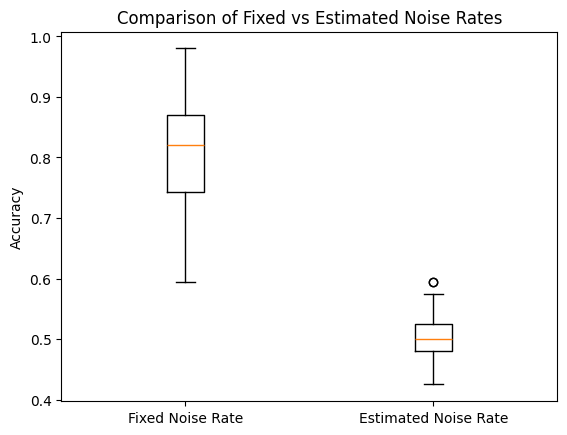

In [2]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from scipy import stats
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, n_samples=1000, n_features=10, noise_rate=0.2, seed=None):
        self.n_samples = n_samples
        self.n_features = n_features
        self.noise_rate = noise_rate
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def generate_data(self, seed):
        """
        Generate a synthetic dataset with noisy labels.
        """

        np.random.seed(seed)
        self.X, self.y = make_classification(n_samples=self.n_samples, n_features=self.n_features, n_classes=2, flip_y=0, n_redundant=4, n_informative=6, random_state=seed)
        self.y = np.where(self.y == 0, -1, 1)

        self.y_noisy = self.y.copy()
        n_noisy = int(self.noise_rate * self.y.shape[0])
        
        # Introduce noise while ensuring no class is fully eliminated
        class_1_indices = np.where(self.y_noisy == 1)[0]
        class_minus_1_indices = np.where(self.y_noisy == -1)[0]
        
        # Apply noise separately to each class, ensuring that we don't end up with an empty class
        if len(class_1_indices) > 1:
            noise_class_1 = np.random.choice(class_1_indices, size=min(len(class_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_1] = -1
        
        if len(class_minus_1_indices) > 1:
            noise_class_minus_1 = np.random.choice(class_minus_1_indices, size=min(len(class_minus_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_minus_1] = 1
    
    def get_data(self, seed):
        """
        Return the generated data.
        """
        self.generate_data(seed)
        return self.X, self.y, self.y_noisy

    def generate_multiple_datasets(self, n_datasets=100):
        """
        Generate multiple datasets for simulation.
        """
        datasets = []
        for i in range(n_datasets):
            seed_i = self.seed + i if self.seed is not None else None
            datasets.append(self.get_data(seed_i))
        return datasets

# Estimate noise rates using Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X) # estimate the distribution of the data points in the feature space X.
    log_density = kde.score_samples(X) # The score_samples method of KDE returns the log of the estimated density for each sample
    density = np.exp(log_density) # Converting the log densities back to actual density values gives us the estimated densities of each data point in X.
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == 0] / density.mean()
    
    # Estimate noise rates
    if p_y0_given_x.size > 0:
        rho_plus_1 = np.min(p_y0_given_x)  # flipped from 0 to 1
    else:
        rho_plus_1 = 0 
    if p_y1_given_x.size > 0:
        rho_minus_1 = np.min(p_y1_given_x)  # flipped from 1 to 0
    else:
        rho_minus_1 = 0
    
    return rho_minus_1, rho_plus_1

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1  # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1  # the likelihood that a sample labeled as 0 is indeed a true negative
    return weights

# Train a logistic regression classifier with weighted samples
def train_classifier(X_train, y_train_noisy, weights):
    clf = LogisticRegression()
    clf.fit(X_train, y_train_noisy, sample_weight=weights)
    return clf

# Evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy


# Main simulation function for both fixed and estimated noise rate scenarios
def simulation_study_comparison(n_datasets=100, n_samples=1000, n_features=10, noise_rate=0.2, 
                                test_size=0.2, seed=None, true_rho_minus_1=0.1, true_rho_plus_1=0.3):
    accuracies_fixed_noise = []
    accuracies_estimated_noise = []
    
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate, seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for X, y, y_noisy in datasets:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)

        # Scenario 1: Fixed (True) Noise Rates
        weights_fixed = compute_importance_weights(y_train, y_train_noisy, true_rho_minus_1, true_rho_plus_1)
        clf_fixed = train_classifier(X_train, y_train_noisy, weights_fixed)
        accuracy_fixed = evaluate_classifier(clf_fixed, X_test, y_test)
        accuracies_fixed_noise.append(accuracy_fixed)

        # Scenario 2: Estimated Noise Rates
        rho_minus_1_est, rho_plus_1_est = estimate_noise_rates(X_train, y_train_noisy)
        weights_estimated = compute_importance_weights(y_train, y_train_noisy, rho_minus_1_est, rho_plus_1_est)
        clf_estimated = train_classifier(X_train, y_train_noisy, weights_estimated)
        accuracy_estimated = evaluate_classifier(clf_estimated, X_test, y_test)
        accuracies_estimated_noise.append(accuracy_estimated)
    
    return accuracies_fixed_noise, accuracies_estimated_noise

# Run the simulation study for both fixed and estimated noise rates
accuracies_fixed_noise, accuracies_estimated_noise = simulation_study_comparison(seed=42)

# Perform a paired t-test to check if there is a significant difference in performance
t_statistic, p_value = stats.ttest_rel(accuracies_fixed_noise, accuracies_estimated_noise)
print(f"Paired t-test results: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}")

# Interpretation of the hypothesis test result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in performance.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in performance.")


## Calculate Cohen's d to measure effect size
# mean_fixed = np.mean(accuracies_fixed_noise)
# mean_estimated = np.mean(accuracies_estimated_noise)
# std_pooled = np.sqrt((np.std(accuracies_fixed_noise, ddof=1) ** 2 + np.std(accuracies_estimated_noise, ddof=1) ** 2) / 2)
# cohens_d = (mean_fixed - mean_estimated) / std_pooled
# print(f"Cohen's d: {cohens_d:.4f}")


# Visualize the results using a boxplot
def visualize_comparison(accuracies_fixed_noise, accuracies_estimated_noise, filename="importance_reweighting_comparison.jpg"):
    data = [accuracies_fixed_noise, accuracies_estimated_noise]
    plt.boxplot(data, labels=['Fixed Noise Rate', 'Estimated Noise Rate'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Fixed vs Estimated Noise Rates')
    # plt.savefig(filename, format='jpg', dpi=300)
    plt.show()

# Visualize the comparison
visualize_comparison(accuracies_fixed_noise, accuracies_estimated_noise)

The very high t-statistic indicates that the difference in performance between the two scenarios (fixed vs. estimated noise rates) is substantial. The p-value of 0.0000 (effectively less than 0.05) strongly supports rejecting the null hypothesis, meaning that there is a significant difference in performance between the fixed noise rate and estimated noise rate scenarios.

The significant difference in performance suggests that the importance reweighting method suffers from noise rate estimation errors, which leads to a noticeable drop in accuracy compared to when the true noise rates are known (fixed). This drop in performance is likely due to the inherent difficulty in accurately estimating noise rates. This aligns with the hypothesis that the lower accuracy of the importance reweighting method is likely due to the estimation of noise rates, whereas the other methods (unbiased estimator and label-dependent costs) assume correct fixed noise rates, leading to better performance.

### Correlated Data

#### Comparison to classic models

Weighted Logistic Regression - Mean accuracy: 0.8226, Standard deviation: 0.0140
Unweighted Logistic Regression - Mean accuracy: 0.8242, Standard deviation: 0.0141
SVM - Mean accuracy: 0.8985, Standard deviation: 0.0196


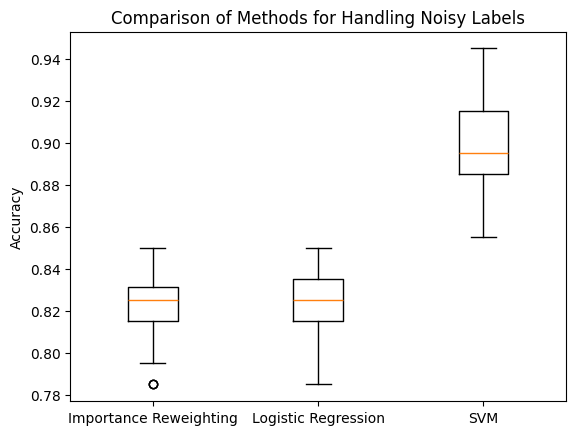

In [9]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt

import sys
sys.path.append('C:/Users/bekon/Master_thesis/modules')
from noisy_data_simulation import NoisyLabelSimulation

# Create a simulated dataset
def run_simulation():
    simulation = NoisyLabelSimulation(n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=42)
    X, y, y_noisy = simulation.get_data()

# Estimate noise rates using Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X)
    log_density = kde.score_samples(X)
    density = np.exp(log_density)
    
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y_minus1_given_x = density[y_noisy == -1] / density.mean()
    
    if p_y1_given_x.size > 0:
        rho_plus_1 = np.min(p_y_minus1_given_x)  # Estimate noise rate for flips from -1 to 1
    else:
        rho_plus_1 = 0 
    if p_y_minus1_given_x.size > 0:
        rho_minus_1 = np.min(p_y1_given_x)  # Estimate noise rate for flips from 1 to -1
    else:
        rho_minus_1 = 0
    
    return rho_minus_1, rho_plus_1

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 / (1 - rho_minus_1) if rho_minus_1 != 0 else 1.0
        else:
            weights[i] = 1 / (1 - rho_plus_1) if rho_plus_1 != 0 else 1.0
    return weights

# Train a logistic regression classifier with weighted samples
def train_classifier(X_train, y_train_noisy, weights):
    clf = LogisticRegression()
    clf.fit(X_train, y_train_noisy, sample_weight=weights)
    return clf

# Evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Main simulation function
def simulation_study(n_datasets=100, n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive=noise_rate_positive, noise_rate_negative=noise_rate_negative, correlation=0.8, seed=seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for X, y, y_noisy in datasets:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)

        rho_minus_1, rho_plus_1 = estimate_noise_rates(X_train, y_train_noisy)
        weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)
        
        # Logistic Regression with Reweighting
        clf_weighted_lr = train_classifier(X_train, y_train_noisy, weights)
        accuracy_weighted_lr = evaluate_classifier(clf_weighted_lr, X_test, y_test)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Reweighting
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        accuracy_unweighted_lr = evaluate_classifier(clf_unweighted_lr, X_test, y_test)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        accuracy_svm = evaluate_classifier(clf_svm, X_test, y_test)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Set a seed for reproducibility
seed = 42

# Run the simulation study with asymmetric noise rates
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=seed)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)

mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)

mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Weighted Logistic Regression - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Boxplot visualization function
def visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="reweighting_cor.jpg"):
    data = [accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm]
    plt.boxplot(data, labels=['Importance Reweighting', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods for Handling Noisy Labels')
    plt.savefig(r'C:\Users\bekon\Master_thesis\graphs\reweighting_cor.jpg', format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies using boxplot
visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm)

#### Hypothesis Testing

Paired t-test results: t-statistic = 20.1056, p-value = 0.0000
Reject the null hypothesis: There is a significant difference in performance.
Cohen's d: 1.9772


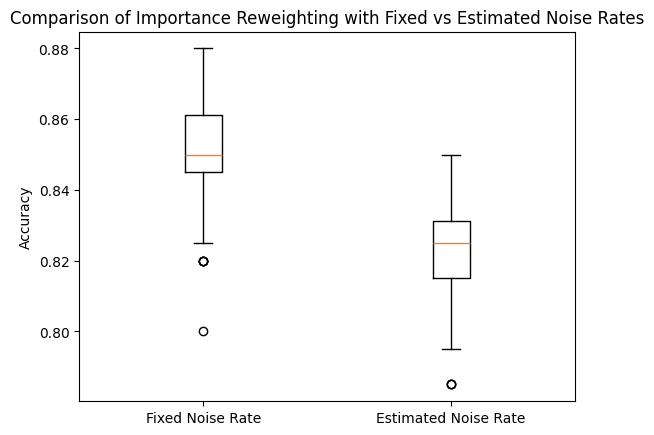

In [8]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from scipy import stats
import matplotlib.pyplot as plt

from noisy_data_simulation import NoisyLabelSimulation

# Create a simulated dataset
def run_simulation():
    simulation = NoisyLabelSimulation(n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3, seed=42)
    X, y, y_noisy = simulation.get_data()

# Estimate noise rates using Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X) # estimate the distribution of the data points in the feature space X.
    log_density = kde.score_samples(X) # The score_samples method of KDE returns the log of the estimated density for each sample
    density = np.exp(log_density) # Converting the log densities back to actual density values gives us the estimated densities of each data point in X.
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == -1] / density.mean()
    
    # Estimate noise rates
    if p_y0_given_x.size > 0:
        rho_plus_1 = np.min(p_y0_given_x)  # flipped from 0 to 1
    else:
        rho_plus_1 = 0 
    if p_y1_given_x.size > 0:
        rho_minus_1 = np.min(p_y1_given_x)  # flipped from 1 to 0
    else:
        rho_minus_1 = 0
    
    return rho_minus_1, rho_plus_1

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 / (1 - rho_minus_1) if rho_minus_1 != 0 else 1.0
        else:
            weights[i] = 1 / (1 - rho_plus_1) if rho_plus_1 != 0 else 1.0
    return weights

# Train a logistic regression classifier with weighted samples
def train_classifier(X_train, y_train_noisy, weights):
    clf = LogisticRegression()
    clf.fit(X_train, y_train_noisy, sample_weight=weights)
    return clf

# Evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Main simulation function for both fixed and estimated noise rate scenarios
def simulation_study_comparison(n_datasets=100, n_samples=1000, n_features=15, noise_rate_positive=0.1, noise_rate_negative=0.3,
                                test_size=0.2, seed=None, true_rho_minus_1=0.1, true_rho_plus_1=0.3):
    accuracies_fixed_noise = []
    accuracies_estimated_noise = []
    
    simulation = NoisyLabelSimulation(n_samples, n_features, noise_rate_positive, noise_rate_negative, correlation=0.8, seed=seed)
    datasets = simulation.generate_multiple_datasets(n_datasets)
    
    for X, y, y_noisy in datasets:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)

        # Scenario 1: Fixed (True) Noise Rates
        weights_fixed = compute_importance_weights(y_train, y_train_noisy, true_rho_minus_1, true_rho_plus_1)
        clf_fixed = train_classifier(X_train, y_train_noisy, weights_fixed)
        accuracy_fixed = evaluate_classifier(clf_fixed, X_test, y_test)
        accuracies_fixed_noise.append(accuracy_fixed)

        # Scenario 2: Estimated Noise Rates
        rho_minus_1_est, rho_plus_1_est = estimate_noise_rates(X_train, y_train_noisy)
        weights_estimated = compute_importance_weights(y_train, y_train_noisy, rho_minus_1_est, rho_plus_1_est)
        clf_estimated = train_classifier(X_train, y_train_noisy, weights_estimated)
        accuracy_estimated = evaluate_classifier(clf_estimated, X_test, y_test)
        accuracies_estimated_noise.append(accuracy_estimated)
    
    return accuracies_fixed_noise, accuracies_estimated_noise

# Run the simulation study for both fixed and estimated noise rates
accuracies_fixed_noise, accuracies_estimated_noise = simulation_study_comparison(seed=42)

# Perform a paired t-test to check if there is a significant difference in performance
t_statistic, p_value = stats.ttest_rel(accuracies_fixed_noise, accuracies_estimated_noise)
print(f"Paired t-test results: t-statistic = {t_statistic:.4f}, p-value = {p_value:.4f}")

# Interpretation of the hypothesis test result
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference in performance.")
else:
    print("Fail to reject the null hypothesis: There is no significant difference in performance.")

# Calculate Cohen's d to measure effect size
mean_fixed = np.mean(accuracies_fixed_noise)
mean_estimated = np.mean(accuracies_estimated_noise)
std_pooled = np.sqrt((np.std(accuracies_fixed_noise, ddof=1) ** 2 + np.std(accuracies_estimated_noise, ddof=1) ** 2) / 2)
cohens_d = (mean_fixed - mean_estimated) / std_pooled
print(f"Cohen's d: {cohens_d:.4f}")

# Visualize the results using a boxplot
def visualize_comparison(accuracies_fixed_noise, accuracies_estimated_noise, filename="importance_reweighting_noise_rates.jpg"):
    data = [accuracies_fixed_noise, accuracies_estimated_noise]
    plt.boxplot(data, labels=['Fixed Noise Rate', 'Estimated Noise Rate'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Importance Reweighting with Fixed vs Estimated Noise Rates')
    plt.savefig(r'C:\Users\bekon\Master_thesis\graphs\importance_reweighting_noise_rates.jpg', format='jpg', dpi=300)
    plt.show()

# Visualize the comparison
visualize_comparison(accuracies_fixed_noise, accuracies_estimated_noise, filename="importance_reweighting_noise_rates.jpg")

#### Effect of Noise Rate on Accuracy

Running simulation for noise_rate=0.1, n_features=15, n_samples=1000
Running simulation for noise_rate=0.1, n_features=15, n_samples=2000
Running simulation for noise_rate=0.1, n_features=15, n_samples=3000
Running simulation for noise_rate=0.1, n_features=20, n_samples=1000
Running simulation for noise_rate=0.1, n_features=20, n_samples=2000
Running simulation for noise_rate=0.1, n_features=20, n_samples=3000
Running simulation for noise_rate=0.1, n_features=30, n_samples=1000
Running simulation for noise_rate=0.1, n_features=30, n_samples=2000
Running simulation for noise_rate=0.1, n_features=30, n_samples=3000
Running simulation for noise_rate=0.2, n_features=15, n_samples=1000
Running simulation for noise_rate=0.2, n_features=15, n_samples=2000
Running simulation for noise_rate=0.2, n_features=15, n_samples=3000
Running simulation for noise_rate=0.2, n_features=20, n_samples=1000
Running simulation for noise_rate=0.2, n_features=20, n_samples=2000
Running simulation for noise_rate=

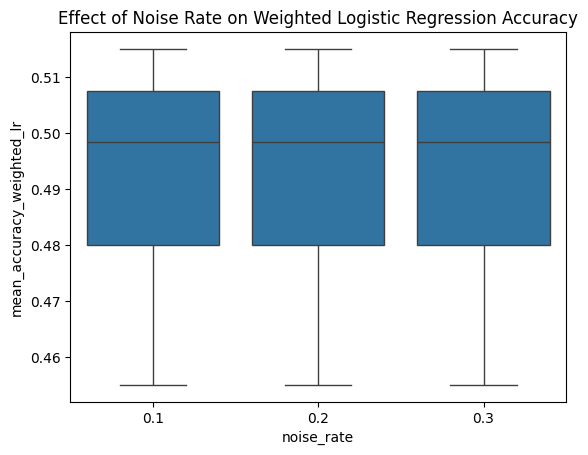

In [47]:
def simulation_study_multiple_configs(noise_rates, n_features_list, n_samples_list, n_datasets=100, test_size=0.2, seed=None):
    results = []

    for noise_rate in noise_rates:
        for n_features in n_features_list:
            for n_samples in n_samples_list:
                print(f"Running simulation for noise_rate={noise_rate}, n_features={n_features}, n_samples={n_samples}")

                accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(
                    n_datasets=n_datasets,
                    n_samples=n_samples,
                    n_features=n_features,
                    noise_rate=noise_rate,
                    test_size=test_size,
                    seed=seed
                )
                print("Simulation run successful.")

                # Store the results with the corresponding parameters
                results.append({
                    'noise_rate': noise_rate,
                    'n_features': n_features,
                    'n_samples': n_samples,
                    'mean_accuracy_weighted_lr': np.mean(accuracies_weighted_lr),
                    'std_accuracy_weighted_lr': np.std(accuracies_weighted_lr),
                    'mean_accuracy_unweighted_lr': np.mean(accuracies_unweighted_lr),
                    'std_accuracy_unweighted_lr': np.std(accuracies_unweighted_lr),
                    'mean_accuracy_svm': np.mean(accuracies_svm),
                    'std_accuracy_svm': np.std(accuracies_svm)
                })
    
    return results


noise_rates = [0.1, 0.2, 0.3]
n_features_list = [15, 20, 30]
n_samples_list = [1000, 2000, 3000]

results = simulation_study_multiple_configs(noise_rates, n_features_list, n_samples_list, n_datasets=100, seed=42)

import pandas as pd
import seaborn as sns

# Convert results to DataFrame for easier analysis
df_results = pd.DataFrame(results)

# Example of how to visualize the effect of noise rate on accuracy
sns.boxplot(x='noise_rate', y='mean_accuracy_weighted_lr', data=df_results)
plt.title("Effect of Noise Rate on Weighted Logistic Regression Accuracy")
plt.show()

### UCI Benchmark Dataset

Importance Reweighting - Mean accuracy: 0.3772, Standard deviation: 0.0000
Unweighted Logistic Regression - Mean accuracy: 0.9143, Standard deviation: 0.0224
SVM - Mean accuracy: 0.9446, Standard deviation: 0.0164


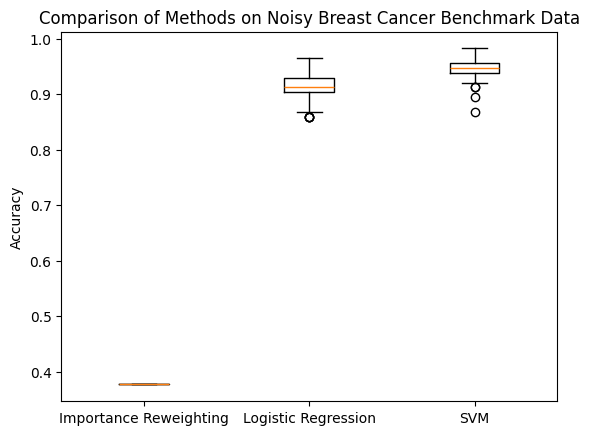

In [6]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

class NoisyLabelSimulation:
    def __init__(self, noise_rate=0.2, seed=None):
        self.noise_rate = noise_rate
        self.seed = seed
        self.X = None
        self.y = None
        self.y_noisy = None
    
    def load_and_preprocess_data(self):
        """
        Load and preprocess the UCI dataset.
        """
        # Load dataset
        data = load_breast_cancer()
        self.X = data.data
        self.y = data.target
        
        # Standardize the features
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)
        
        # Convert labels from {0, 1} to {-1, 1}
        self.y = np.where(self.y == 0, -1, 1)
    
    def introduce_noise(self):
        """
        Introduce noise into the labels.
        """
        self.y_noisy = self.y.copy()
        n_noisy = int(self.noise_rate * self.y.shape[0])
        
        # Introduce noise while ensuring no class is fully eliminated
        class_1_indices = np.where(self.y_noisy == 1)[0]
        class_minus_1_indices = np.where(self.y_noisy == -1)[0]
        
        # Apply noise separately to each class
        if len(class_1_indices) > 1:
            noise_class_1 = np.random.choice(class_1_indices, size=min(len(class_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_1] = -1
        
        if len(class_minus_1_indices) > 1:
            noise_class_minus_1 = np.random.choice(class_minus_1_indices, size=min(len(class_minus_1_indices) - 1, int(n_noisy / 2)), replace=False)
            self.y_noisy[noise_class_minus_1] = 1
    
    def get_data(self):
        """
        Return the data with noisy labels.
        """
        self.load_and_preprocess_data()
        self.introduce_noise()
        return self.X, self.y, self.y_noisy

# Estimate noise rates using Kernel Density Estimation (KDE)
def estimate_noise_rates(X, y_noisy):
    kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(X) # estimate the distribution of the data points in the feature space X.
    log_density = kde.score_samples(X) # The score_samples method of KDE returns the log of the estimated density for each sample
    density = np.exp(log_density) # Converting the log densities back to actual density values gives us the estimated densities of each data point in X.
    
    # Estimate conditional probabilities
    p_y1_given_x = density[y_noisy == 1] / density.mean()
    p_y0_given_x = density[y_noisy == 0] / density.mean()
    
    # Estimate noise rates
    if p_y0_given_x.size > 0:
        rho_plus_1 = np.min(p_y0_given_x)  # flipped from 0 to 1
    else:
        rho_plus_1 = 0 
    if p_y1_given_x.size > 0:
        rho_minus_1 = np.min(p_y1_given_x)  # flipped from 1 to 0
    else:
        rho_minus_1 = 0
    
    return rho_minus_1, rho_plus_1

# Compute importance weights
def compute_importance_weights(y_true, y_noisy, rho_minus_1, rho_plus_1):
    weights = np.zeros_like(y_noisy, dtype=float)
    for i in range(len(y_noisy)):
        if y_noisy[i] == 1:
            weights[i] = 1 - rho_minus_1  # the likelihood that a sample labeled as 1 is indeed a true positive
        else:
            weights[i] = 1 - rho_plus_1  # the likelihood that a sample labeled as 0 is indeed a true negative
    return weights

# Train a logistic regression classifier with weighted samples
def train_classifier(X_train, y_train_noisy, weights):
    clf = LogisticRegression()
    clf.fit(X_train, y_train_noisy, sample_weight=weights)
    return clf

# Evaluate the classifier
def evaluate_classifier(clf, X_test, y_test):
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Main simulation function
def simulation_study(n_datasets=100, noise_rate=0.2, test_size=0.2, seed=None):
    accuracies_weighted_lr = []
    accuracies_unweighted_lr = []
    accuracies_svm = []
    simulation = NoisyLabelSimulation(noise_rate, seed)
    
    for i in range(n_datasets):
        X, y, y_noisy = simulation.get_data()
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)
        _, _, y_train_noisy, _ = train_test_split(X, y_noisy, test_size=test_size, random_state=seed)

        rho_minus_1, rho_plus_1 = estimate_noise_rates(X_train, y_train_noisy)
        weights = compute_importance_weights(y_train, y_train_noisy, rho_minus_1, rho_plus_1)
        
        # Logistic Regression with Reweighting
        clf_weighted_lr = train_classifier(X_train, y_train_noisy, weights)
        accuracy_weighted_lr = evaluate_classifier(clf_weighted_lr, X_test, y_test)
        accuracies_weighted_lr.append(accuracy_weighted_lr)
        
        # Logistic Regression without Reweighting
        clf_unweighted_lr = LogisticRegression()
        clf_unweighted_lr.fit(X_train, y_train_noisy)
        accuracy_unweighted_lr = evaluate_classifier(clf_unweighted_lr, X_test, y_test)
        accuracies_unweighted_lr.append(accuracy_unweighted_lr)
        
        # SVM without Reweighting
        clf_svm = SVC()
        clf_svm.fit(X_train, y_train_noisy)
        accuracy_svm = evaluate_classifier(clf_svm, X_test, y_test)
        accuracies_svm.append(accuracy_svm)
    
    return accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm

# Set a seed for reproducibility
seed = 42

# Run the simulation study
accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm = simulation_study(seed=seed)

# Calculate mean and standard deviation of accuracies for each method
mean_accuracy_weighted_lr = np.mean(accuracies_weighted_lr)
std_accuracy_weighted_lr = np.std(accuracies_weighted_lr)

mean_accuracy_unweighted_lr = np.mean(accuracies_unweighted_lr)
std_accuracy_unweighted_lr = np.std(accuracies_unweighted_lr)

mean_accuracy_svm = np.mean(accuracies_svm)
std_accuracy_svm = np.std(accuracies_svm)

print(f"Importance Reweighting - Mean accuracy: {mean_accuracy_weighted_lr:.4f}, Standard deviation: {std_accuracy_weighted_lr:.4f}")
print(f"Unweighted Logistic Regression - Mean accuracy: {mean_accuracy_unweighted_lr:.4f}, Standard deviation: {std_accuracy_unweighted_lr:.4f}")
print(f"SVM - Mean accuracy: {mean_accuracy_svm:.4f}, Standard deviation: {std_accuracy_svm:.4f}")

# Boxplot visualization function
def visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="reweighting_uci.jpg"):
    data = [accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm]
    plt.boxplot(data, labels=['Importance Reweighting', 'Logistic Regression', 'SVM'])
    plt.ylabel('Accuracy')
    plt.title('Comparison of Methods on Noisy Breast Cancer Benchmark Data')
    plt.savefig(r'C:\Users\bekon\Master_thesis\graphs\reweighting_uci.jpg', format='jpg', dpi=300)
    plt.show()

# Visualize the accuracies using boxplot
visualize_boxplot(accuracies_weighted_lr, accuracies_unweighted_lr, accuracies_svm, filename="reweighting_uci.jpg")